In [30]:
#!/usr/bin/env python3
"""
    File Name: CNN Trainer.ipynb
    Author: Thomas Frew
    Date created: 08/01/2023
    Date last modified: 24/01/2023
    Python Version: 3.11
    
    Reads "Dataset.csv", training data for a computer vision AI.
    This can be in one of two forms:

        - 2D: Images are labelled with coordinates, defining the center of some object of interest
        - 4D: Images are labelled with coordinates, defining the bounding box around some object of interest

    This data is then used to train a convolutional neural network
    (CNN) with a preprogrammed architecture. Users can select the
    number epochs the AI is trained for, visualise its training
    progress and view its predictions.
"""

In [ ]:
# Import tensorflow for machine learning
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Import cv2 for image manipulation
import cv2

# Import Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import random for rnadomisation
import random

In [31]:
# Load the training dataset. This can be generated with "2D Dataset Generator.ipynb or 4D Dataset Generator.ipynb"
dataset = pd.read_csv("Dataset.csv")

# Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Store the number of dimensions in the training data
output_dim = len(dataset.columns) - 1

# If the training dataset is 2D, then we are tracking center points
if (output_dim == 2):
    dataset.columns = ["Filename","x","y"]
    
    # Visualise the first 5 rows of the dataset
    print("The first 5 rows of your dataset are:")
    print(dataset.head())
    
# If the training dataset is 4D, then we are tracking bounding boxes
elif (output_dim == 4):
    dataset.columns = ["Filename","x1","y1","x2","y2"]

    # Visualise the first 5 rows of the dataset
    print("The first 5 rows of your dataset are:")
    print(dataset.head())
    
# Otherwise, something has gone wrong
else:
    print("Input data not in 2D (center-point) or 4D (bounding box) format.")

The first 5 rows of your dataset are:
                                            Filename   x1  y1   x2  y2
0  C:\Users\thoma\OneDrive - University of Adelai...   88  35  103  50
1  C:\Users\thoma\OneDrive - University of Adelai...  122  42  138  62
2  C:\Users\thoma\OneDrive - University of Adelai...   75  24   92  42
3  C:\Users\thoma\OneDrive - University of Adelai...   70  13   87  37
4  C:\Users\thoma\OneDrive - University of Adelai...  144  67  170  98


In [32]:
# Split the image filenames (col 0) from their coordinate data (cols 1-2 or 1-4)
coords = dataset.copy()
file_names = coords.pop('Filename')

In [33]:
# Load each file as its RGB image data
image_data = []

for fname in file_names:
    image_data.append(cv2.imread(fname))
    
# Store the length and width of each image
input_len, input_wid, channels = image_data[0].shape
    
# Report the image shape data
print(f"Your images are {input_len} by {input_wid} with {channels} color channels.")

Your images are 108 by 192 with 3 color channels.


In [34]:
# Create a Convolutional Neural Network to predict the location of our centers/bounding boxes
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(input_len, input_wid, channels))) # Depends on inage size
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(400, activation='relu'))
model.add(layers.Dense(100))
model.add(layers.Dense(30))
model.add(layers.Dense(output_dim)) # Depends on output dimensions

In [35]:
# Visualise the model
print("The model's structure is:")
print(model.summary())

The model's structure is:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 106, 190, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 53, 95, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 93, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 44, 64)        36928     
                                                                 
 flatten_1 (Flatten)        

In [36]:
# Convert the training images and labels to numpy arrays
image_data = np.asarray(image_data)
coords = np.asarray(coords)

In [37]:
# Split up data into training and testing with a 9:1 ratio
datapoints = len(coords)
split_index = int(datapoints*0.1)

train_data = image_data[split_index:]
test_data = image_data[:split_index]

train_labels = coords[split_index:]
test_labels = coords[:split_index]

In [39]:
model.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
epochs = int(input("How many epochs do you want the CNN to be trained for?\n>> "))

history = model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels))

How many epochs do you want the CNN to be trained for?
>> 1
133/133 [==============================] - 162s 1s/step - loss: 526.4629 - accuracy: 0.8377 - val_loss: 90.3283 - val_accuracy: 0.9362


In [49]:
# Ask the user if they would like to save the current model
user_input = input("Would you like to save this AI as a file? (Y/n)\n>> ")

# If yes, save the model, to the current directory, in the folder "Model"
if (user_input == 'Y'):
    model.save("Model")
    print("AI successfully saved.")

Would you like to save this AI? (Y/n)
>> Y


INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


AI successfully saved.


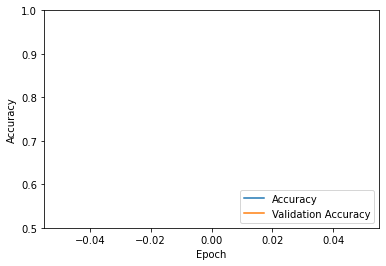

In [41]:
# Plot the training and validation accuracy, over time
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [42]:
# Make the AI predict on all test data, and store these predictions
predictions = model.predict(test_data)

15/15 [==============================] - 3s 213ms/step


In [73]:
# Ask the user how many test evaluations they would like to see
n_plots = int(input("How many training outputs would you like to see? (≥2)\n>> ")

# Create an n x 1 subplot to display n tests
fig, axes = plt.subplots(1, n_plots, figsize=(15, 60)) 

# Display the first 5 test images and the AI's guess as to where their center is
for i in range(0,n_plots):
              
    # Select a random test image, and display it
    randi = random.randrange(split_index)
    axes[i].imshow(test_data[randi])

    # If the AI should detect the center of some object of interest...
    if (output_dim == 2):
        # Create a patch and place it in the center of the image
        pred_point = patches.Rectangle((predictions[i][0], predictions[i][1]), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
        axes[i].add_patch(pred_point)

        true_point = patches.Rectangle((test_labels[i][0], test_labels[i][1]), 2, 2, linewidth=2, edgecolor='b', facecolor='none')
        axes[i].add_patch(true_point)
              
    # If the AI should detect a bounding box around some object of interest...
    elif (output_dim == 4):
              
        # Create a red bounding box around where the AI thinks the object is
        pred_len = predictions[randi][2] - predictions[randi][0]
        pred_wid = predictions[randi][3] - predictions[randi][1]

        pred_box = patches.Rectangle((predictions[randi][0], predictions[randi][1]), pred_len, pred_wid, linewidth=2, edgecolor='r', facecolor='none')
        axes[i].add_patch(pred_box)

        # Create a blue bounding box around where the object actually is
        true_len = test_labels[randi][2] - test_labels[randi][0]
        true_wid = test_labels[randi][3] - test_labels[randi][1]

        true_box = patches.Rectangle((test_labels[randi][0], test_labels[randi][1]), true_len, true_wid, linewidth=2, edgecolor='b', facecolor='none')
        axes[i].add_patch(true_box)

    # Otherwise, something has gone wrong
    else:
        print("Input data not in 2D (center-point) or 4D (bounding box) format.")
        
# Create a legend for the plot, automatically positioned
plt.legend(['Prediction', 'Ground Truth'])

How many training outputs would you like to see?
>> 0


ValueError: Number of columns must be a positive integer, not 0

<Figure size 1080x4320 with 0 Axes>